In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches




# Load the data 

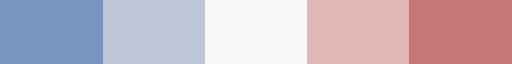

In [2]:
newcmp = list(sns.color_palette("vlag",5))
newcmp[2] = "#F9F9F9"
newcmp = ListedColormap(newcmp)   
newcmp

## scRNA

In [3]:
adata_sc = sc.read("../data/interim/cnv.h5ad")


In [4]:
adata_sc.obs["leiden"] = adata_sc.obs["leiden"].astype("category")

In [9]:
adata_sc.obs["leiden"] = adata_sc.obs["leiden"].replace('3',17)
adata_sc.obs["leiden"] = adata_sc.obs["leiden"].replace('17','3')
adata_sc.obs["leiden"] = adata_sc.obs["leiden"].replace(17,'17')

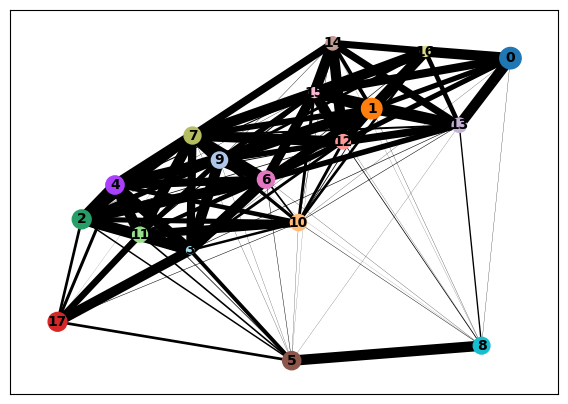

In [10]:
sc.tl.paga(adata_sc)
sc.pl.paga(adata_sc, plot=True) 

/home/o313a/miniconda3/envs/sq_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/o313a/miniconda3/envs/sq_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


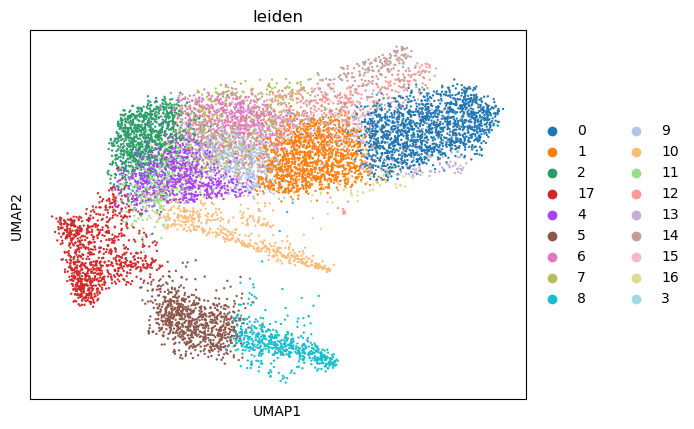

In [11]:
sc.tl.umap(adata_sc, init_pos='paga')

sc.pl.umap(adata_sc, color=["leiden"])

In [12]:
clones_sc = adata_sc.obs["leiden"]

In [13]:
clones = clones_sc.values

In [14]:
clones

['16', '16', '10', '10', '10', ..., '2', '17', '2', '2', '17']
Length: 10721
Categories (18, object): ['0', '1', '2', '17', ..., '14', '15', '16', '3']

In [15]:
tmp_sc = adata_sc.X

In [16]:
cons_sc = []
sc_clone_size = {}
for cl in range(len(set(clones))):
    idx = np.where(clones == str(cl))[0]
    values = tmp_sc[idx,:]
    values = np.median(values, axis = 0)
    cons_sc.append(values)
    sc_clone_size[cl] = len(idx)
    

In [17]:
sc_clone_size

{0: 1567,
 1: 1320,
 2: 949,
 3: 22,
 4: 837,
 5: 817,
 6: 666,
 7: 615,
 8: 583,
 9: 517,
 10: 512,
 11: 376,
 12: 321,
 13: 314,
 14: 230,
 15: 70,
 16: 67,
 17: 938}

In [18]:
dist_clones = adata_sc.uns['paga']['connectivities'].todense()

In [19]:
cons_sc = pd.DataFrame(cons_sc, columns = adata_sc.var.index)

In [20]:
chroms = pd.read_csv("../data/interim/FRP_copykat_CNA_results.txt", sep = "\t",usecols = ["chrom","abspos"] )

In [21]:
chroms = chroms.set_index("abspos")

/home/o313a/miniconda3/envs/sq_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


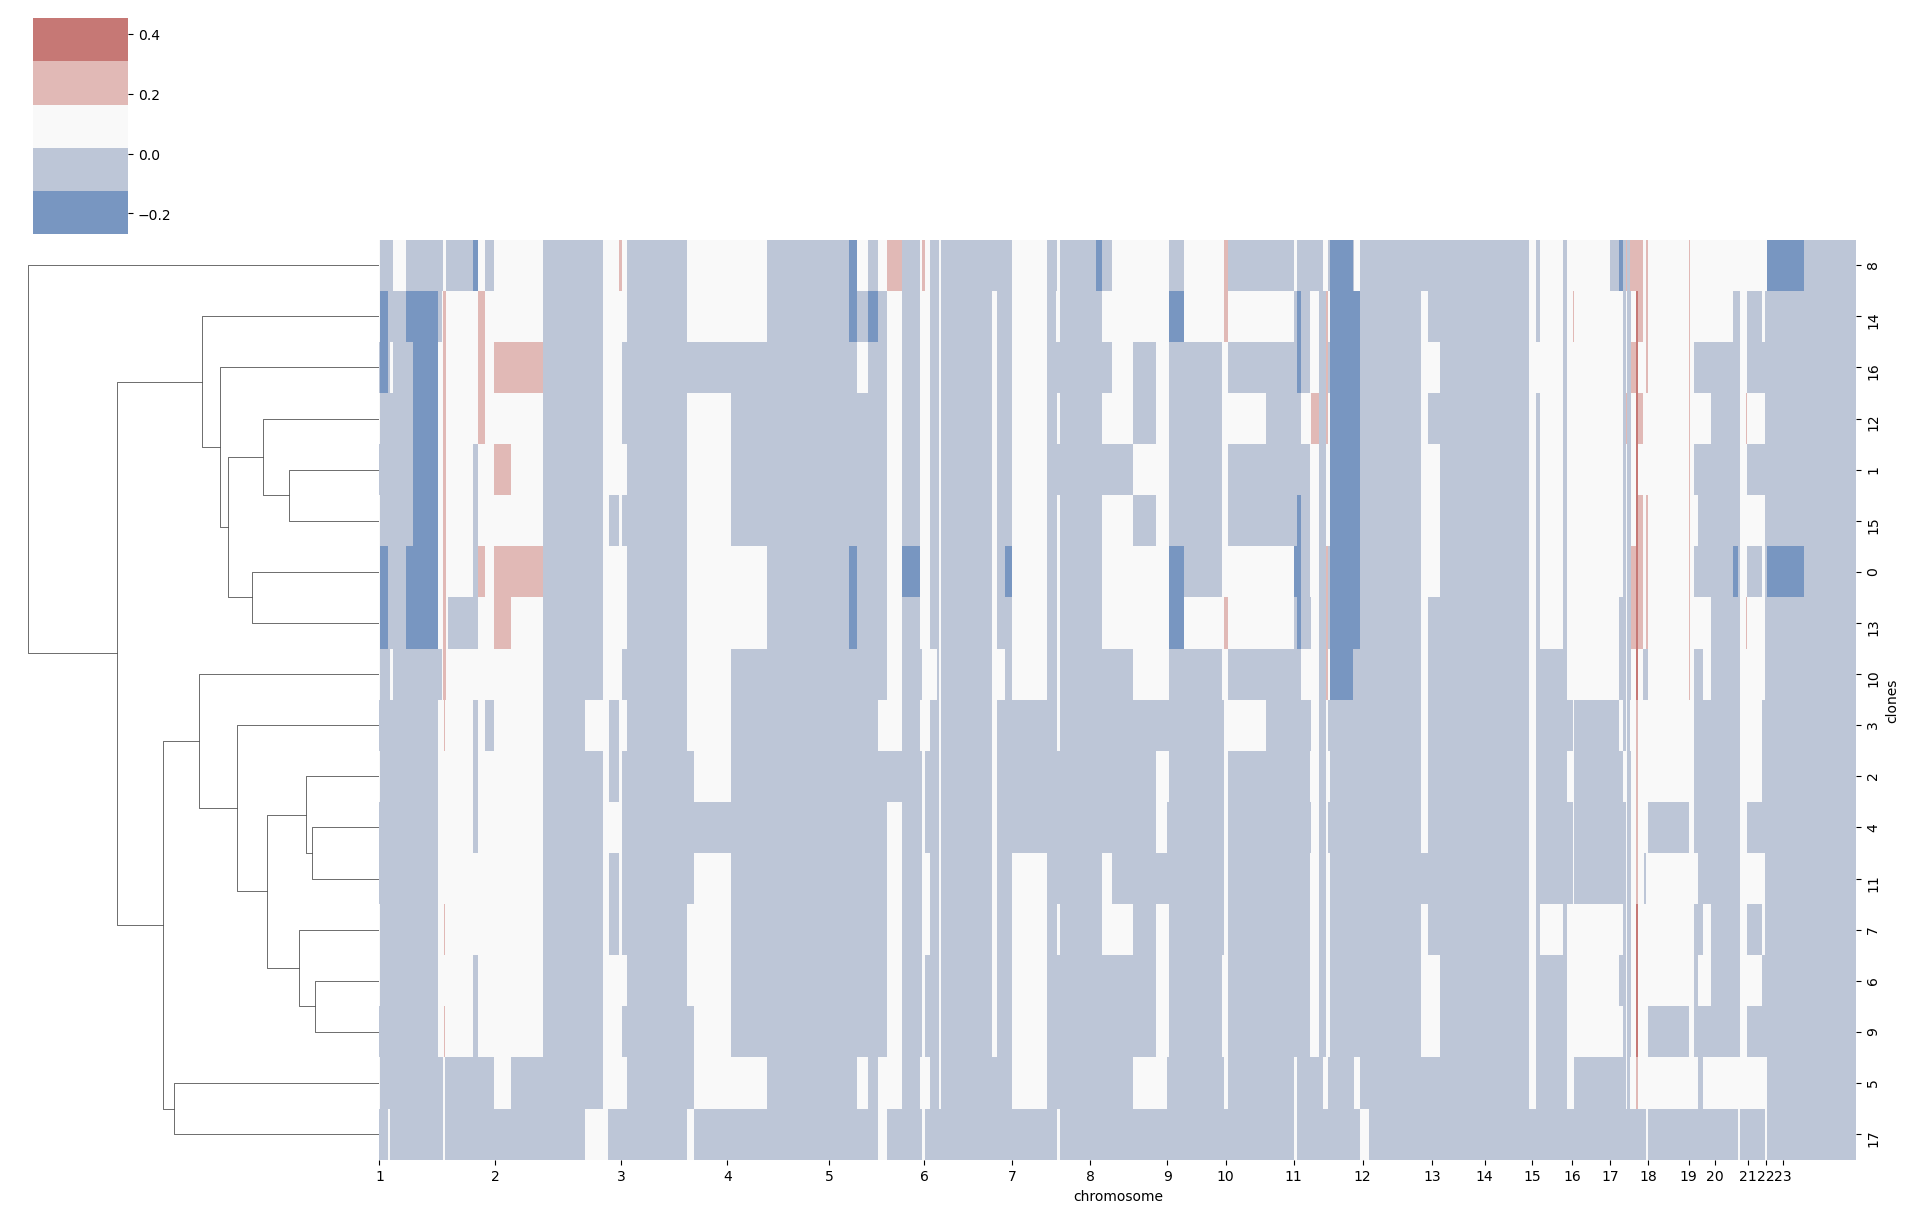

In [22]:

g = sns.clustermap(cons_sc, cmap = newcmp, figsize = (19,12), xticklabels = False,
                   col_cluster = False, row_cluster = True)
ax = g.ax_heatmap
ax.set_xlabel("chromosome")
ax.set_ylabel("clones")
cut_chroms = chroms.chrom

ax.set_xticks(range(0, len(cut_chroms)), cut_chroms)
xticks = ax.xaxis.get_major_ticks()
prev = ""
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == prev:
        label.set_visible(False)
        xticks[i].set_visible(False)
    prev = label.get_text()




/home/o313a/miniconda3/envs/sq_env/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/o313a/miniconda3/envs/sq_env/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


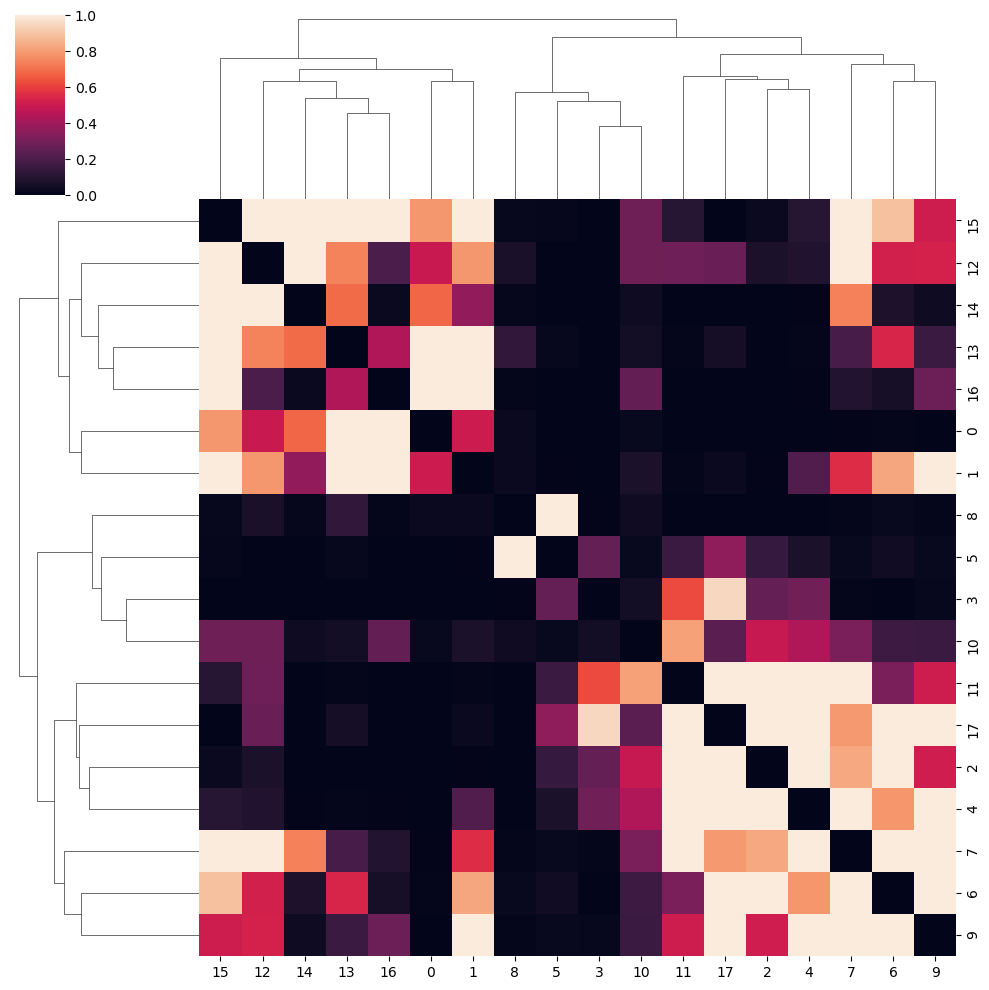

In [23]:
sns.clustermap(dist_clones)

<Axes: >

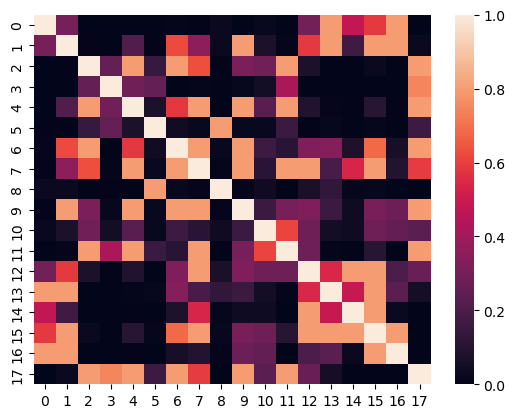

In [24]:
def apply_penalty(matrix, threshold, penalty):
    # Create a copy of the matrix
    result = np.copy(matrix)
    
    # Apply penalty to values larger than the threshold
    result[result > threshold] -= penalty
    
    # Fill the main diagonal with 1
    np.fill_diagonal(result, 1)
    
    return result

dist = apply_penalty(dist_clones,0.3,0.2)
sns.heatmap(dist)

In [25]:
np.save("../data/interim/clone_dist_over.npy",dist)

In [34]:
adata_sc.obs["leiden"] = adata_sc.obs["leiden"].replace("17", "diploid")

In [26]:
adata_sc.obs["leiden"].to_csv("../data/interim/clones_over.csv")

In [27]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor,DistanceCalculator
from scipy.spatial import distance



In [28]:
matrix = dist_clones

In [29]:
dist_matrix = []

for i in range(len(matrix)):
    row = []
    for j in range(i + 1):  # Include only the lower triangle elements
        row.append(np.sum(abs(matrix[i,:] - matrix[j,:])))
    dist_matrix.append(row)



In [30]:

names = [str(x) for x in np.arange(matrix.shape[0])]
distance_matrix = DistanceMatrix(names=names, matrix=dist_matrix)

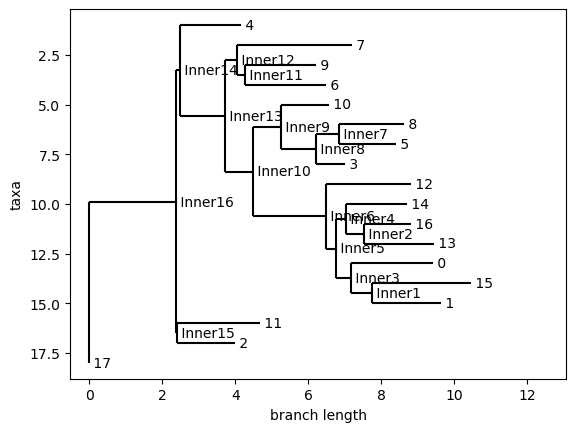

In [31]:
# Perform hierarchical clustering
constructor = DistanceTreeConstructor()
tree = constructor.nj(distance_matrix)

# Set the root at node 0
tree.root_with_outgroup({'name': '17'})

# Draw the tree
Phylo.draw(tree)

<Figure size 1000x1000 with 0 Axes>

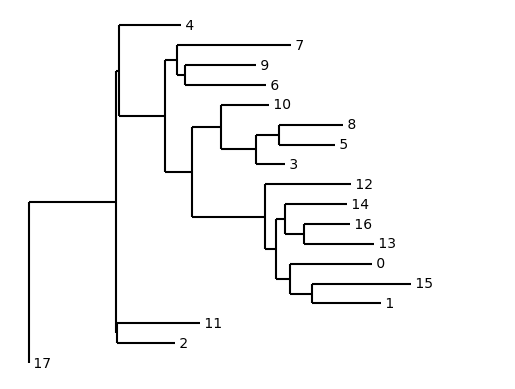

In [32]:
# Hide inner node labels
for clade in tree.find_clades():
    if not clade.is_terminal():
        clade.name = ''

# Draw the tree without inner node labels
plt.figure(figsize=(10, 10))
Phylo.draw(tree, do_show=False)
plt.axis('off')
plt.show()